# observations_refit_csv

## setup

In [48]:
from lxml import etree
import os
import pandas as pd
import csvw_functions
import json
from rdflib import Graph, SOSA, URIRef
import csv

## Read in the data

In [49]:
data_dir=r'C:\Users\cvskf\OneDrive - Loughborough University\_Data\REFIT_Smart_Home_dataset_PUBLIC_v1\Data'

In [50]:
tree=etree.parse(os.path.join(data_dir,'REFIT_BUILDING_SURVEY.xml'))
NS={'refit':'http://www.refitsmarthomes.org'}
tree

## Get refit csv headings

In [51]:
pd.read_csv(os.path.join(data_dir,r'REFIT_TIME_SERIES_VALUES.csv'),nrows=1)

,TimeSeriesVariable/@id,dateTime,data
0,TimeSeriesVariable1,2013-10-02T05:00:00Z,17.772


## get tsv_dicts

### tsv_id:tsv_node

In [52]:
tsv_node_dict={n.get('id'):n for n in tree.xpath('//refit:TimeSeriesVariable',namespaces=NS)}
len(tsv_node_dict), next(iter(tsv_node_dict.items())) 

(2457,
 ('TimeSeriesVariable1573',
  <Element {http://www.refitsmarthomes.org}TimeSeriesVariable at 0x27799605fc0>))

### what are the parent nodes of the tsv_nodes?

And their tag, manufaturer and model properties

In [53]:
set((n.getparent().tag,n.getparent().get('manufacturer'),n.getparent().get('model')) for n in tsv_node_dict.values())

{('{http://www.refitsmarthomes.org}Appliance', 'RWE', 'Smart Home Control'),
 ('{http://www.refitsmarthomes.org}RadiatorValve', 'RWE', 'TRV'),
 ('{http://www.refitsmarthomes.org}Sensor',
  'CurrentCost',
  'Individual appliance monitor (IAM)'),
 ('{http://www.refitsmarthomes.org}Sensor', 'CurrentCost', 'Mains clamp'),
 ('{http://www.refitsmarthomes.org}Sensor', 'Enica', 'Pulse logger'),
 ('{http://www.refitsmarthomes.org}Sensor', 'Maxim', 'iButton'),
 ('{http://www.refitsmarthomes.org}Sensor', 'Onset', 'Hobo U12'),
 ('{http://www.refitsmarthomes.org}Sensor', 'Onset', 'Hobo pendant'),
 ('{http://www.refitsmarthomes.org}Sensor', 'RWE', 'Alarm'),
 ('{http://www.refitsmarthomes.org}Sensor', 'RWE', 'Appliance plug'),
 ('{http://www.refitsmarthomes.org}Sensor', 'RWE', 'Contact sensor'),
 ('{http://www.refitsmarthomes.org}Sensor', 'RWE', 'Exterior motion detector'),
 ('{http://www.refitsmarthomes.org}Sensor', 'RWE', 'Interior motion detector'),
 ('{http://www.refitsmarthomes.org}Sensor', 'RWE

### get madeBySensor

In [54]:
def get_madeBySensor(tsv_node):
    ""
    n=tsv_node.getparent()
    st=''
    manufacturer=n.get('manufacturer')
    if manufacturer:
        st+=manufacturer.replace(' ','_') + '_'
    model=n.get('model')
    if model:
        st+=model.replace(' ','_') + '_' 
    st+=n.get('id')
    return st
    
madeBySensor_dict={k:get_madeBySensor(v) for k,v in tsv_node_dict.items()}
len(madeBySensor_dict), next(iter(madeBySensor_dict.items())) 

(2457, ('TimeSeriesVariable1573', 'Sensor1247'))

### get usedProcedure

In [55]:
def get_usedProcedure(tsv_id):
    ""
    return 'Procedure'+tsv_id.removeprefix('TimeSeriesVariable')

usedProcedure_dict={k:get_usedProcedure(k) for k in tsv_node_dict}
len(usedProcedure_dict), next(iter(usedProcedure_dict.items())) 

(2457, ('TimeSeriesVariable1573', 'Procedure1573'))

### get hasFeatureOfInterest

In [56]:
def get_hasFeatureOfInterest(tsv_node):
    ""
    x=tsv_node.getparent()
    if 'Sensor' in x.tag:
        x=x.getparent()
    return x.get('id')

hasFeatureOfInterest_dict={k:get_hasFeatureOfInterest(v) for k,v in tsv_node_dict.items()}
len(hasFeatureOfInterest_dict), next(iter(hasFeatureOfInterest_dict.items())) 

(2457, ('TimeSeriesVariable1573', 'Climate1'))

### get observedProperty

In [57]:
def get_observedProperty(tsv_node):
    ""
    return tsv_node.get('variableType').replace(' ','_')

observedProperty_dict={k:get_observedProperty(v) for k,v in tsv_node_dict.items()}
len(observedProperty_dict), next(iter(observedProperty_dict.items())) 

(2457, ('TimeSeriesVariable1573', 'Air_temperature'))

### get unit and multiplier

In [58]:
def get_unit_and_multiplier(tsv_node):
    ""
    x=tsv_node.get('units')
    if x in ['C','Deg','Deg C','degrees C']:
        return 'DEG_C', 1
    elif x=='%':
        return 'PERCENT', 1
    elif x=='Cubic metres':
        return 'M3', 1
    elif x=='Lux':
        return 'LUX', 1
    elif x=='MJ/m^2':
        return 'J-PER-M2',1000000
    elif x=='W':
        return 'W',1
    elif x=='W/m^2':
        return 'W-PER-m2', 1
    elif x=='hPa':
        return 'HectoPa', 1
    elif x=='kW/m^2':
        return 'W-PER-M2', 1000
    elif x=='m/s':
        return 'M-PER-SEC', 1
    elif x=='mm':
        return 'MilliM', 1
    elif x is None:
        return '', 1
    else:
        raise Exception(x)
        
unit_and_multiplier_dict={k:get_unit_and_multiplier(v) for k,v in tsv_node_dict.items()}
len(unit_and_multiplier_dict), next(iter(unit_and_multiplier_dict.items())) 

(2457, ('TimeSeriesVariable1573', ('DEG_C', 1)))

In [59]:
unit_dict={k:v[0] for k,v in unit_and_multiplier_dict.items()}
len(unit_dict), next(iter(unit_dict.items())) 

(2457, ('TimeSeriesVariable1573', 'DEG_C'))

In [60]:
multiplier_dict={k:v[1] for k,v in unit_and_multiplier_dict.items()}
len(multiplier_dict), next(iter(multiplier_dict.items())) 

(2457, ('TimeSeriesVariable1573', 1))

In [61]:
def get_output_row(input_row):
    ""
    tsv_id, dateTime, data=input_row
    
    multiplier=multiplier_dict[tsv_id]
    
    if multiplier==1:
        value=data
    else:
        value=str(float(data)*multiplier)
    
    return [
        'Observation',
        madeBySensor_dict[tsv_id],
        usedProcedure_dict[tsv_id],
        hasFeatureOfInterest_dict[tsv_id],
        observedProperty_dict[tsv_id],
        value,
        unit_dict[tsv_id],
        dateTime
    ]
    
get_output_row(['TimeSeriesVariable1','2013-10-02T05:00:00Z','17.772'])

['Observation',
 'Onset_Hobo_U12_Sensor1',
 'Procedure1',
 'Space13',
 'Air_temperature',
 '17.772',
 'DEG_C',
 '2013-10-02T05:00:00Z']

## Loop through refit csv

In [66]:
with open('observation_sensor_data.csv','w', newline='') as f1:
    csvwriter=csv.writer(f1)

    with open(os.path.join(data_dir,r'REFIT_TIME_SERIES_VALUES.csv')) as f:
        csvreader = csv.reader(f)

        for i,input_row in enumerate(csvreader):
            
            if i%1000000==0:
                print(i, end=' ')
            
            if i==0:
                
                csvwriter.writerow(['id','type','madeBySensor','usedProcedure','hasFeatureOfInterest',
                                    'observedProperty','value','unit','resultTime'])
                
            else:
            
                csvwriter.writerow([f'Observation{str(i)}']+get_output_row(input_row))
            
            #if i==2: break
            
print('DONE')

0 1000000 2000000 3000000 4000000 5000000 6000000 7000000 8000000 9000000 10000000 11000000 12000000 13000000 14000000 15000000 16000000 17000000 18000000 19000000 20000000 21000000 22000000 23000000 24000000 25000000 DONE


## Tests

In [68]:
df=pd.read_csv('observation_sensor_data.csv',
               #nrows=1
               na_filter=False,
               parse_dates=['resultTime']
              )
df

,id,type,madeBySensor,usedProcedure,hasFeatureOfInterest,observedProperty,value,unit,resultTime
0,Observation1,Observation,Onset_Hobo_U12_Sensor1,Procedure1,Space13,Air_temperature,17.772,DEG_C,2013-10-02 05:00:00+00:00
1,Observation2,Observation,Onset_Hobo_U12_Sensor1,Procedure1,Space13,Air_temperature,18.081,DEG_C,2013-10-02 05:30:00+00:00
2,Observation3,Observation,Onset_Hobo_U12_Sensor1,Procedure1,Space13,Air_temperature,18.176,DEG_C,2013-10-02 06:00:00+00:00
3,Observation4,Observation,Onset_Hobo_U12_Sensor1,Procedure1,Space13,Air_temperature,18.176,DEG_C,2013-10-02 06:30:00+00:00
4,Observation5,Observation,Onset_Hobo_U12_Sensor1,Procedure1,Space13,Air_temperature,18.105,DEG_C,2013-10-02 07:00:00+00:00
...,...,...,...,...,...,...,...,...,...
25312392,Observation25312393,Observation,RWE_Smoke_detector_Sensor1449,Procedure2359,Building16,Alarm,-10005.000,,2014-12-02 16:33:00+00:00
25312393,Observation25312394,Observation,RWE_Smoke_detector_Sensor1449,Procedure2359,Building16,Alarm,-10005.000,,2014-12-28 13:22:00+00:00
25312394,Observation25312395,Observation,RWE_Smoke_detector_Sensor1449,Procedure2359,Building16,Alarm,-10005.000,,2015-02-17 08:39:00+00:00
25312395,Observation25312396,Observation,RWE_Smoke_detector_Sensor1449,Procedure2359,Building16,Alarm,-10005.000,,2015-02-28 08:09:00+00:00


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25312397 entries, 0 to 25312396
Data columns (total 9 columns):
 #   Column                Dtype              
---  ------                -----              
 0   id                    object             
 1   type                  object             
 2   madeBySensor          object             
 3   usedProcedure         object             
 4   hasFeatureOfInterest  object             
 5   observedProperty      object             
 6   value                 float64            
 7   unit                  object             
 8   resultTime            datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(1), object(7)
memory usage: 1.7+ GB


### find air temperatures measured by Hobo sensors in 2014

In [71]:
df[df.madeBySensor.str.startswith('Onset') 
   & (df.observedProperty=='Air_temperature')
   & (df.resultTime>=pd.Timestamp('2014-01-01T00:00:00Z'))
   & (df.resultTime<pd.Timestamp('2015-01-01T00:00:00Z'))
  ]

,id,type,madeBySensor,usedProcedure,hasFeatureOfInterest,observedProperty,value,unit,resultTime
4354,Observation4355,Observation,Onset_Hobo_U12_Sensor2,Procedure2,Space13,Air_temperature,17.677222,DEG_C,2014-01-01 00:00:00+00:00
4355,Observation4356,Observation,Onset_Hobo_U12_Sensor2,Procedure2,Space13,Air_temperature,17.937778,DEG_C,2014-01-01 00:30:00+00:00
4356,Observation4357,Observation,Onset_Hobo_U12_Sensor2,Procedure2,Space13,Air_temperature,18.247222,DEG_C,2014-01-01 01:00:00+00:00
4357,Observation4358,Observation,Onset_Hobo_U12_Sensor2,Procedure2,Space13,Air_temperature,17.486111,DEG_C,2014-01-01 01:30:00+00:00
4358,Observation4359,Observation,Onset_Hobo_U12_Sensor2,Procedure2,Space13,Air_temperature,17.011111,DEG_C,2014-01-01 02:00:00+00:00
...,...,...,...,...,...,...,...,...,...
8041986,Observation8041987,Observation,Onset_Hobo_pendant_Sensor425,Procedure425,Space151,Air_temperature,18.426000,DEG_C,2014-12-31 22:45:00+00:00
8041987,Observation8041988,Observation,Onset_Hobo_pendant_Sensor425,Procedure425,Space151,Air_temperature,18.426000,DEG_C,2014-12-31 23:00:00+00:00
8041988,Observation8041989,Observation,Onset_Hobo_pendant_Sensor425,Procedure425,Space151,Air_temperature,18.521000,DEG_C,2014-12-31 23:15:00+00:00
8041989,Observation8041990,Observation,Onset_Hobo_pendant_Sensor425,Procedure425,Space151,Air_temperature,18.616000,DEG_C,2014-12-31 23:30:00+00:00


### find air temperatures measured by Hobo sensors in 2014 in Building01

In [74]:
df_survey=pd.read_csv('observation_survey_data.csv')
building01_space_ids=\
    df_survey[(df_survey.observedProperty=='hasBuilding') & (df_survey.hasResult=='Building01')].hasFeatureOfInterest.values
building01_space_ids

array(['Space1', 'Space2', 'Space3', 'Space4', 'Space5', 'Space6',
       'Space7', 'Space8', 'Space9', 'Space10', 'Space11', 'Space12',
       'Space13', 'Space14', 'Space15', 'Space16', 'Space17', 'Space18',
       'Space325', 'Space346'], dtype=object)

In [78]:
df_result=df[df.madeBySensor.str.startswith('Onset') 
   & (df.observedProperty=='Air_temperature')
   & (df.resultTime>=pd.Timestamp('2014-01-01T00:00:00Z'))
   & (df.resultTime<pd.Timestamp('2015-01-01T00:00:00Z'))
   & (df.hasFeatureOfInterest.isin(building01_space_ids))
  ]
df_result

,id,type,madeBySensor,usedProcedure,hasFeatureOfInterest,observedProperty,value,unit,resultTime
4354,Observation4355,Observation,Onset_Hobo_U12_Sensor2,Procedure2,Space13,Air_temperature,17.677222,DEG_C,2014-01-01 00:00:00+00:00
4355,Observation4356,Observation,Onset_Hobo_U12_Sensor2,Procedure2,Space13,Air_temperature,17.937778,DEG_C,2014-01-01 00:30:00+00:00
4356,Observation4357,Observation,Onset_Hobo_U12_Sensor2,Procedure2,Space13,Air_temperature,18.247222,DEG_C,2014-01-01 01:00:00+00:00
4357,Observation4358,Observation,Onset_Hobo_U12_Sensor2,Procedure2,Space13,Air_temperature,17.486111,DEG_C,2014-01-01 01:30:00+00:00
4358,Observation4359,Observation,Onset_Hobo_U12_Sensor2,Procedure2,Space13,Air_temperature,17.011111,DEG_C,2014-01-01 02:00:00+00:00
...,...,...,...,...,...,...,...,...,...
586115,Observation586116,Observation,Onset_Hobo_pendant_Sensor43,Procedure43,Space1,Air_temperature,16.618000,DEG_C,2014-12-31 22:45:00+00:00
586116,Observation586117,Observation,Onset_Hobo_pendant_Sensor43,Procedure43,Space1,Air_temperature,16.713000,DEG_C,2014-12-31 23:00:00+00:00
586117,Observation586118,Observation,Onset_Hobo_pendant_Sensor43,Procedure43,Space1,Air_temperature,16.713000,DEG_C,2014-12-31 23:15:00+00:00
586118,Observation586119,Observation,Onset_Hobo_pendant_Sensor43,Procedure43,Space1,Air_temperature,16.713000,DEG_C,2014-12-31 23:30:00+00:00


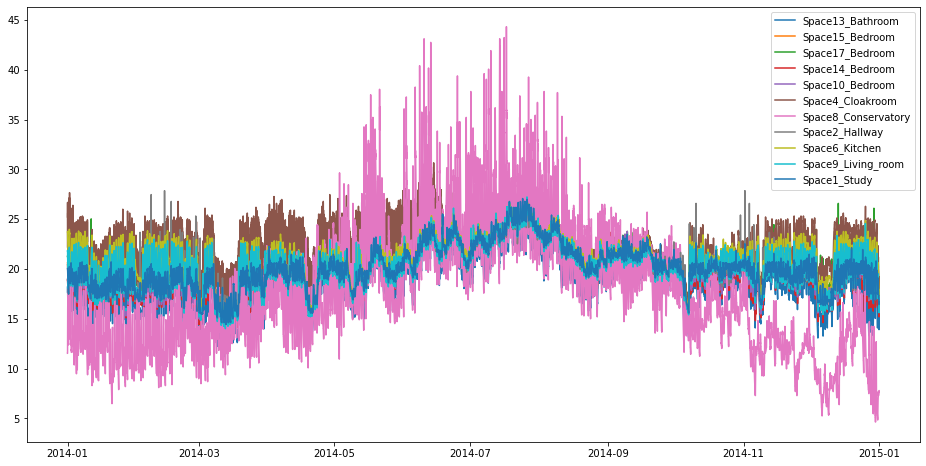

In [85]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,8))
for space_id in df_result.hasFeatureOfInterest.unique():
    x=df_result[df_result.hasFeatureOfInterest==space_id]
    label=(space_id+'_'
           + df_survey[(df_survey.observedProperty=='roomType') & (df_survey.hasFeatureOfInterest==space_id)].hasResult.values[0])
    ax.plot(x.resultTime,x.value, label=label)
ax.legend()